# Load model pth, make sure the 3dunet could load it.

In [3]:
import torch
import os
import matplotlib.pyplot as plt
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# read model dict
model_dict = torch.load('3DUNet.pth')

In [4]:
# Convert odict_keys object to list and print the first key
state_dict_values = list(model_dict['state_dict'].values())
# print(len(state_dict_values))
state_dict_keys = list(model_dict['state_dict'].keys())
# print(len(state_dict_keys))
print(state_dict_keys)

# save all key and value in a dictionary
state_dict = {}
for i in range(len(state_dict_keys)):
    state_dict[state_dict_keys[i]] = state_dict_values[i]

# # print all shapes of the tensors
# for key in state_dict:
#     print(key, state_dict[key].shape)
#     # write key, all shapes of the tensors in a file
#     with open('model_shapes.txt', 'a') as f:
#         string = key + ' ' + str(state_dict[key].shape) + '\n'
#         f.write(string)

state_dict

['model.model.0.0.weight', 'model.model.0.0.bias', 'model.model.1.0.weight', 'model.model.1.0.bias', 'model.model.2.model.1.0.weight', 'model.model.2.model.1.0.bias', 'model.model.2.model.2.0.weight', 'model.model.2.model.2.0.bias', 'model.model.2.model.3.model.1.0.weight', 'model.model.2.model.3.model.1.0.bias', 'model.model.2.model.3.model.2.0.weight', 'model.model.2.model.3.model.2.0.bias', 'model.model.2.model.3.model.3.model.1.0.weight', 'model.model.2.model.3.model.3.model.1.0.bias', 'model.model.2.model.3.model.3.model.2.0.weight', 'model.model.2.model.3.model.3.model.2.0.bias', 'model.model.2.model.3.model.3.model.3.model.1.0.weight', 'model.model.2.model.3.model.3.model.3.model.1.0.bias', 'model.model.2.model.3.model.3.model.3.model.2.0.weight', 'model.model.2.model.3.model.3.model.3.model.2.0.bias', 'model.model.2.model.3.model.3.model.3.model.3.weight', 'model.model.2.model.3.model.3.model.3.model.3.bias', 'model.model.2.model.3.model.3.model.4.0.weight', 'model.model.2.mode

{'model.model.0.0.weight': tensor([[[[[ 0.1712, -0.1893,  0.1579],
            [-0.1313,  0.0114, -0.1731],
            [ 0.1145,  0.1372, -0.0276]],
 
           [[ 0.1334,  0.0277,  0.0010],
            [ 0.0812,  0.0161, -0.0559],
            [-0.0177, -0.1701, -0.1540]],
 
           [[ 0.0395, -0.0314, -0.1457],
            [ 0.1269, -0.0056,  0.1282],
            [ 0.0341,  0.0965, -0.0606]]]],
 
 
 
         [[[[ 0.0314,  0.0353, -0.1655],
            [-0.0999,  0.1461, -0.1728],
            [-0.0224, -0.1431,  0.0344]],
 
           [[-0.0896,  0.1345,  0.1451],
            [-0.0107,  0.0950, -0.1715],
            [ 0.0383,  0.1412,  0.0805]],
 
           [[-0.1862, -0.0405, -0.1238],
            [ 0.0728, -0.1653, -0.1435],
            [ 0.1618,  0.1837,  0.1119]]]],
 
 
 
         [[[[-0.1318,  0.0996,  0.0510],
            [-0.1870, -0.1946, -0.1513],
            [-0.1068,  0.1757,  0.1519]],
 
           [[-0.0673,  0.0993,  0.0560],
            [-0.1337, -0.0098, -0.0186]

# Original 3dUNet class

In [5]:
import torch
from torch import nn
from typing import Union, Tuple, List
import numpy as np

# Defines the submodule with skip connection.
# X -------------------identity---------------------- X
#   |-- downsampling -- |submodule| -- upsampling --|
class UnetSkipConnectionBlock(nn.Module):
    def __init__(self, in_channels=None, out_channels=None, num_classes=1, kernel_size=3,
                 submodule=None, outermost=False, innermost=False, norm_layer=nn.InstanceNorm3d, use_dropout=False, scale=0):
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        # downconv
        pool = nn.MaxPool3d(3, stride=2, padding=1)
        pool_2 = nn.MaxPool3d(3, stride=[1,2,2], padding=1)
        conv1 = self.contract(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, norm_layer=norm_layer)
        conv2 = self.contract(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, norm_layer=norm_layer)

        # upconv
        conv3 = self.expand(in_channels=out_channels*2, out_channels=out_channels, kernel_size=kernel_size)
        conv4 = self.expand(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size)

        # outermost means the last layer
        if outermost:
            final = nn.Conv3d(out_channels, num_classes, kernel_size=1)
            down = [conv1, conv2]
            up = [conv3, conv4, final]
            model = down + [submodule] + up
        # innermost means the first layer
        elif innermost:
            upconv = nn.ConvTranspose3d(in_channels*2, in_channels,
                                        kernel_size=2, stride=[1,2,2])
            # print("convT:", upconv.weight.data.shape)
            model = [pool_2, conv1, conv2, upconv]
        # else the middle layer, the num of middle layer is defined by scale
        else:
            if scale < 3: # scale is the depth of the network
                upconv = nn.ConvTranspose3d(in_channels*2, in_channels, kernel_size=2, stride=2)
                down = [pool, conv1, conv2]
                up = [conv3, conv4, upconv]
            else:
                upconv = nn.ConvTranspose3d(in_channels * 2, in_channels, kernel_size=2, stride=[1,2,2])
                down = [pool_2, conv1, conv2]
                up = [conv3, conv4, upconv]
            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model) # *model means unpack the list, e.g. [1,2,3] -> 1,2,3,

    @staticmethod
    def contract(in_channels, out_channels, kernel_size=3, norm_layer=nn.InstanceNorm3d):
        layer = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size, padding=1),
            # norm_layer(out_channels),
            nn.LeakyReLU(inplace=True))
        return layer

    @staticmethod
    def expand(in_channels, out_channels, kernel_size=3):
        layer = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size, padding=1),
            nn.LeakyReLU(inplace=True),
        )
        return layer

    # not needed
    @staticmethod
    def center_crop(layer, target_depth, target_width, target_height):
        # center_crop is used to crop the output of each layer to the same size as the input
        batch_size, n_channels, layer_depth, layer_width, layer_height = layer.size() # output from a layer
        xy0 = (layer_depth - target_depth) // 2
        xy1 = (layer_width - target_width) // 2
        xy2 = (layer_height - target_height) // 2
        return layer[:, :, xy0:(xy0 + target_depth), xy1:(xy1 + target_width), xy2:(xy2 + target_height)]

    def forward(self, x):
        #print("1,",x.shape)
        if self.outermost:
            return self.model(x)
        else:
            crop = self.center_crop(self.model(x), x.size()[2], x.size()[3], x.size()[4])
            return torch.cat([x, crop], 1) 
        

class UNet3D(nn.Module):
    def __init__(self, num_classes=4, in_channels=1, initial_filter_size=64, kernel_size=3, num_downs=4, norm_layer=nn.InstanceNorm3d):
        super(UNet3D, self).__init__()

        # construct unet structure, the first layer
        unet_block = UnetSkipConnectionBlock(in_channels=initial_filter_size * 2 ** (num_downs-1), out_channels=initial_filter_size * 2 ** num_downs,
                                             num_classes=num_classes, kernel_size=kernel_size, norm_layer=norm_layer, innermost=True, scale=0)
        # add middle layers with num_downs layers
        for i in range(1, num_downs):
            unet_block = UnetSkipConnectionBlock(in_channels=initial_filter_size * 2 ** (num_downs-(i+1)),
                                                 out_channels=initial_filter_size * 2 ** (num_downs-i),
                                                 num_classes=num_classes, kernel_size=kernel_size, submodule=unet_block, norm_layer=norm_layer, scale=i)
        # the last layer
        unet_block = UnetSkipConnectionBlock(in_channels=in_channels, out_channels=initial_filter_size,
                                             num_classes=num_classes, kernel_size=kernel_size, submodule=unet_block, norm_layer=norm_layer,
                                             outermost=True, scale=num_downs)

        self.model = unet_block
        # self._gaussian_3d = self._patch_size_for_gaussian_3d = None
        # self.inference_apply_nonlin = lambda x: x
        self.num_class = num_classes

    def forward(self, x):
        return self.model(x)



In [6]:
model = UNet3D()
model.load_state_dict(state_dict)
print(model)
# torch summarymodel
from torchsummary import summary
# summary(model, (1, 64, 64, 64), device='cpu')


UNet3D(
  (model): UnetSkipConnectionBlock(
    (model): Sequential(
      (0): Sequential(
        (0): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): LeakyReLU(negative_slope=0.01, inplace=True)
      )
      (1): Sequential(
        (0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): LeakyReLU(negative_slope=0.01, inplace=True)
      )
      (2): UnetSkipConnectionBlock(
        (model): Sequential(
          (0): MaxPool3d(kernel_size=3, stride=[1, 2, 2], padding=1, dilation=1, ceil_mode=False)
          (1): Sequential(
            (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (1): LeakyReLU(negative_slope=0.01, inplace=True)
          )
          (2): Sequential(
            (0): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (1): LeakyReLU(negative_slope=0.01, inplace=True)
          )
          (3): UnetSkipCon

In [7]:
'''
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
            Conv3d-1       [-1, 64, 64, 64, 64]           1,792
         LeakyReLU-2       [-1, 64, 64, 64, 64]               0
            Conv3d-3       [-1, 64, 64, 64, 64]         110,656
         LeakyReLU-4       [-1, 64, 64, 64, 64]               0
         MaxPool3d-5       [-1, 64, 64, 32, 32]               0
            Conv3d-6      [-1, 128, 64, 32, 32]         221,312
         LeakyReLU-7      [-1, 128, 64, 32, 32]               0
            Conv3d-8      [-1, 128, 64, 32, 32]         442,496
         LeakyReLU-9      [-1, 128, 64, 32, 32]               0
        MaxPool3d-10      [-1, 128, 32, 16, 16]               0
           Conv3d-11      [-1, 256, 32, 16, 16]         884,992
        LeakyReLU-12      [-1, 256, 32, 16, 16]               0
           Conv3d-13      [-1, 256, 32, 16, 16]       1,769,728
        LeakyReLU-14      [-1, 256, 32, 16, 16]               0
        MaxPool3d-15        [-1, 256, 16, 8, 8]               0
           Conv3d-16        [-1, 512, 16, 8, 8]       3,539,456
        LeakyReLU-17        [-1, 512, 16, 8, 8]               0
           Conv3d-18        [-1, 512, 16, 8, 8]       7,078,400
        LeakyReLU-19        [-1, 512, 16, 8, 8]               0
        MaxPool3d-20        [-1, 512, 16, 4, 4]               0
           Conv3d-21       [-1, 1024, 16, 4, 4]      14,156,800
        LeakyReLU-22       [-1, 1024, 16, 4, 4]               0
           Conv3d-23       [-1, 1024, 16, 4, 4]      28,312,576
        LeakyReLU-24       [-1, 1024, 16, 4, 4]               0
  ConvTranspose3d-25        [-1, 512, 17, 8, 8]       4,194,816
concat_with LeakyReLU-19       [-1, 1024, 16, 8, 8]               0
           Conv3d-27        [-1, 512, 16, 8, 8]      14,156,288
        LeakyReLU-28        [-1, 512, 16, 8, 8]               0
           Conv3d-29        [-1, 512, 16, 8, 8]       7,078,400
        LeakyReLU-30        [-1, 512, 16, 8, 8]               0
  ConvTranspose3d-31      [-1, 256, 32, 16, 16]       1,048,832
concat_with LeakyReLU-14      [-1, 512, 32, 16, 16]               0
           Conv3d-33      [-1, 256, 32, 16, 16]       3,539,200
        LeakyReLU-34      [-1, 256, 32, 16, 16]               0
           Conv3d-35      [-1, 256, 32, 16, 16]       1,769,728
        LeakyReLU-36      [-1, 256, 32, 16, 16]               0
  ConvTranspose3d-37      [-1, 128, 64, 32, 32]         262,272
concat_with LeakyReLU-9      [-1, 256, 64, 32, 32]               0
           Conv3d-39      [-1, 128, 64, 32, 32]         884,864
        LeakyReLU-40      [-1, 128, 64, 32, 32]               0
           Conv3d-41      [-1, 128, 64, 32, 32]         442,496
        LeakyReLU-42      [-1, 128, 64, 32, 32]               0
  ConvTranspose3d-43       [-1, 64, 65, 64, 64]          65,600
concat_with LeakyReLU-4      [-1, 128, 64, 64, 64]               0
           Conv3d-45       [-1, 64, 64, 64, 64]         221,248
        LeakyReLU-46       [-1, 64, 64, 64, 64]               0
           Conv3d-47       [-1, 64, 64, 64, 64]         110,656
        LeakyReLU-48       [-1, 64, 64, 64, 64]               0
           Conv3d-49        [-1, 4, 64, 64, 64]             260
================================================================
Total params: 90,292,868
Trainable params: 90,292,868
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 1.00
Forward/backward pass size (MB): 2401.25
Params size (MB): 344.44
Estimated Total Size (MB): 2746.69
----------------------------------------------------------------

'''

'\n----------------------------------------------------------------\n        Layer (type)               Output Shape         Param #\n================================================================\n            Conv3d-1       [-1, 64, 64, 64, 64]           1,792\n         LeakyReLU-2       [-1, 64, 64, 64, 64]               0\n            Conv3d-3       [-1, 64, 64, 64, 64]         110,656\n         LeakyReLU-4       [-1, 64, 64, 64, 64]               0\n         MaxPool3d-5       [-1, 64, 64, 32, 32]               0\n            Conv3d-6      [-1, 128, 64, 32, 32]         221,312\n         LeakyReLU-7      [-1, 128, 64, 32, 32]               0\n            Conv3d-8      [-1, 128, 64, 32, 32]         442,496\n         LeakyReLU-9      [-1, 128, 64, 32, 32]               0\n        MaxPool3d-10      [-1, 128, 32, 16, 16]               0\n           Conv3d-11      [-1, 256, 32, 16, 16]         884,992\n        LeakyReLU-12      [-1, 256, 32, 16, 16]               0\n           Conv3d-13

# New Class, checking all middle results. flat version

In [8]:
'''
UNet3D(
  (model): UnetSkipConnectionBlock(
    (model): Sequential(
      (0): Sequential(
        (0): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): LeakyReLU(negative_slope=0.01, inplace=True)
      )
      (1): Sequential(
        (0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): LeakyReLU(negative_slope=0.01, inplace=True)
      )
      (2): UnetSkipConnectionBlock(
        (model): Sequential(
          (0): MaxPool3d(kernel_size=3, stride=[1, 2, 2], padding=1, dilation=1, ceil_mode=False)
          (1): Sequential(
            (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (1): LeakyReLU(negative_slope=0.01, inplace=True)
          )
          (2): Sequential(
            (0): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (1): LeakyReLU(negative_slope=0.01, inplace=True)
          )
          (3): UnetSkipConnectionBlock(
            (model): Sequential(
              (0): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
              (1): Sequential(
                (0): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
                (1): LeakyReLU(negative_slope=0.01, inplace=True)
              )
              (2): Sequential(
                (0): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
                (1): LeakyReLU(negative_slope=0.01, inplace=True)
              )
              (3): UnetSkipConnectionBlock(
                (model): Sequential(
                  (0): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
                  (1): Sequential(
                    (0): Conv3d(256, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
                    (1): LeakyReLU(negative_slope=0.01, inplace=True)
                  )
                  (2): Sequential(
                    (0): Conv3d(512, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
                    (1): LeakyReLU(negative_slope=0.01, inplace=True)
                  )
                  (3): UnetSkipConnectionBlock(
                    (model): Sequential(
                      (0): MaxPool3d(kernel_size=3, stride=[1, 2, 2], padding=1, dilation=1, ceil_mode=False)
                      (1): Sequential(
                        (0): Conv3d(512, 1024, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
                        (1): LeakyReLU(negative_slope=0.01, inplace=True)
                      )
                      (2): Sequential(
                        (0): Conv3d(1024, 1024, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
                        (1): LeakyReLU(negative_slope=0.01, inplace=True)
                      )
                      (3): ConvTranspose3d(1024, 512, kernel_size=(2, 2, 2), stride=(1, 2, 2))
                    )
                  )
                  (4): Sequential(
                    (0): Conv3d(1024, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
                    (1): LeakyReLU(negative_slope=0.01, inplace=True)
                  )
                  (5): Sequential(
                    (0): Conv3d(512, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
                    (1): LeakyReLU(negative_slope=0.01, inplace=True)
                  )
                  (6): ConvTranspose3d(512, 256, kernel_size=(2, 2, 2), stride=(2, 2, 2))
                )
              )
              (4): Sequential(
                (0): Conv3d(512, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
                (1): LeakyReLU(negative_slope=0.01, inplace=True)
              )
              (5): Sequential(
                (0): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
                (1): LeakyReLU(negative_slope=0.01, inplace=True)
              )
              (6): ConvTranspose3d(256, 128, kernel_size=(2, 2, 2), stride=(2, 2, 2))
            )
          )
          (4): Sequential(
            (0): Conv3d(256, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (1): LeakyReLU(negative_slope=0.01, inplace=True)
          )
          (5): Sequential(
            (0): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (1): LeakyReLU(negative_slope=0.01, inplace=True)
          )
          (6): ConvTranspose3d(128, 64, kernel_size=(2, 2, 2), stride=(1, 2, 2))
        )
      )
      (3): Sequential(
        (0): Conv3d(128, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): LeakyReLU(negative_slope=0.01, inplace=True)
      )
      (4): Sequential(
        (0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): LeakyReLU(negative_slope=0.01, inplace=True)
      )
      (5): Conv3d(64, 4, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    )
  )
)
write the class using above information
'''

import torch.nn as nn
import numpy as np
import time

def center_crop(layer, target_depth, target_width, target_height):
    # center_crop is used to crop the output of each layer to the same size as the input
    batch_size, n_channels, layer_depth, layer_width, layer_height = layer.size() # output from a layer
    xy0 = (layer_depth - target_depth) // 2
    xy1 = (layer_width - target_width) // 2
    xy2 = (layer_height - target_height) // 2
    return layer[:, :, xy0:(xy0 + target_depth), xy1:(xy1 + target_width), xy2:(xy2 + target_height)]


class UNet3D_check(nn.Module):
    def __init__(self):
        super(UNet3D_check, self).__init__()
        self.leaky = nn.LeakyReLU(negative_slope=0.01, inplace=True)
        self.maxpool1 = nn.MaxPool3d(kernel_size=3, stride=[1,2,2], padding=1, dilation=1, ceil_mode=False)
        self.maxpool2 = nn.MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        
        self.conv1 = nn.Conv3d(1, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=1)

        self.conv3 = nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv3d(128, 128, kernel_size=3, stride=1, padding=1)

        self.conv5 = nn.Conv3d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv3d(256, 256, kernel_size=3, stride=1, padding=1)

        self.conv7 = nn.Conv3d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv8 = nn.Conv3d(512, 512, kernel_size=3, stride=1, padding=1)

        self.conv9 = nn.Conv3d(512, 1024, kernel_size=3, stride=1, padding=1)
        self.conv10 = nn.Conv3d(1024, 1024, kernel_size=3, stride=1, padding=1)
        self.deconv1 = nn.ConvTranspose3d(1024, 512, kernel_size=2, stride=[1,2,2], padding=0)
        
        self.conv11 = nn.Conv3d(1024, 512, kernel_size=3, stride=1, padding=1)
        self.conv12 = nn.Conv3d(512, 512, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose3d(512, 256, kernel_size=2, stride=2, padding=0)
        
        self.conv13 = nn.Conv3d(512, 256, kernel_size=3, stride=1, padding=1)
        self.conv14 = nn.Conv3d(256, 256, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose3d(256, 128, kernel_size=2, stride=2, padding=0)

        self.conv15 = nn.Conv3d(256, 128, kernel_size=3, stride=1, padding=1)
        self.conv16 = nn.Conv3d(128, 128, kernel_size=3, stride=1, padding=1)
        self.deconv4 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=[1,2,2], padding=0)

        self.conv17 = nn.Conv3d(128, 64, kernel_size=3, stride=1, padding=1)
        self.conv18 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv19 = nn.Conv3d(64, 4, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x1 = self.leaky(self.conv1(x))
        # save x1 as numpy array
        # np.save('baseline/conv1.npy', x1.detach().numpy())

        x1 = self.leaky(self.conv2(x1))
        # np.save('baseline/conv2.npy', x1.detach().numpy())
        x1p = self.maxpool1(x1)

        x2 = self.leaky(self.conv3(x1p))
        # np.save('baseline/conv3.npy', x2.detach().numpy())
        x2 = self.leaky(self.conv4(x2))
        # np.save('baseline/conv4.npy', x2.detach().numpy())
        x2p = self.maxpool2(x2)

        x3 = self.leaky(self.conv5(x2p))
        x3 = self.leaky(self.conv6(x3))
        x3p = self.maxpool2(x3)

        x4 = self.leaky(self.conv7(x3p))
        x4 = self.leaky(self.conv8(x4))
        x4p = self.maxpool1(x4)

        x5 = self.leaky(self.conv9(x4p))
        x5 = self.leaky(self.conv10(x5))
        x5 = self.deconv1(x5)
        x5 = center_crop(x5, x4.size()[2], x4.size()[3], x4.size()[4]) # ok
        # np.save('baseline/deconv1_crop.npy', x5.detach().numpy())

        x6 = torch.cat([x4, x5], dim=1)
        x6 = self.leaky(self.conv11(x6))
        # np.save('baseline/conv11.npy', x6.detach().numpy())
        x6 = self.leaky(self.conv12(x6))
        # np.save('baseline/conv12.npy', x6.detach().numpy())
        x6 = self.deconv2(x6)
        x6 = center_crop(x6, x3.size()[2], x3.size()[3], x3.size()[4])
        # np.save('baseline/deconv2_crop.npy', x6.detach().numpy())

        x7 = torch.cat([x3, x6], dim=1)
        x7 = self.leaky(self.conv13(x7))
        # np.save('baseline/conv13.npy', x7.detach().numpy())
        x7 = self.leaky(self.conv14(x7))
        # np.save('baseline/conv14.npy', x7.detach().numpy())
        x7 = self.deconv3(x7)
        x7 = center_crop(x7, x2.size()[2], x2.size()[3], x2.size()[4])
        # np.save('baseline/deconv3_crop.npy', x7.detach().numpy())

        x8 = torch.cat([x2, x7], dim=1)
        np.save('conv3d_1-35.npy', x8.detach().numpy())
        # x8 = self.leaky(self.conv15(x8))
        time1 = time.perf_counter()
        x8 = self.conv15(x8)
        time2 = time.perf_counter()
        print(time2-time1)
        np.save('conv3d_1-36.npy', x8.detach().numpy())
        x8 = self.leaky(x8)
        # np.save('baseline/conv15.npy', x8.detach().numpy())
        x8 = self.leaky(self.conv16(x8))
        # np.save('baseline/conv16.npy', x8.detach().numpy())
        x8 = self.deconv4(x8)
        x8 = center_crop(x8, x1.size()[2], x1.size()[3], x1.size()[4])
        # np.save('baseline/deconv4_crop.npy', x8.detach().numpy())

        x9 = torch.cat([x1, x8], dim=1)
        x9 = self.leaky(self.conv17(x9))
        # np.save('baseline/conv17.npy', x9.detach().numpy())
        x9 = self.leaky(self.conv18(x9))
        # np.save('baseline/conv18.npy', x9.detach().numpy())
        x9 = self.conv19(x9)
        # np.save('baseline/conv19.npy', x9.detach().numpy())

        return x9

model_ck = UNet3D_check()

# load the pre trained weights and bias
def loadWB(model, path):
    i = 0
    for name, param in model.named_parameters():
        if (param.requires_grad) and 'weight' in name:
            w = np.loadtxt(path + str(i+1) + '.txt')
            w = w.reshape(param.shape)
            w = torch.from_numpy(w).float()
            param.data = w

        if (param.requires_grad) and 'bias' in name:
            b = np.loadtxt(path + str(i) + '.txt')
            b = b.reshape(param.shape)
            b = torch.from_numpy(b).float()
            param.data = b
            
            i += 2

    return model

# load the pre trained weights and bias
model_ck = loadWB(model_ck, 'output/savedWB2/')
# print(model_ck.conv1.weight.data)

# SUMMARY

In [10]:
import torch.nn as nn
import numpy as np
import time

def center_crop(layer, target_depth, target_width, target_height):
    # center_crop is used to crop the output of each layer to the same size as the input
    batch_size, n_channels, layer_depth, layer_width, layer_height = layer.size() # output from a layer
    xy0 = (layer_depth - target_depth) // 2
    xy1 = (layer_width - target_width) // 2
    xy2 = (layer_height - target_height) // 2
    return layer[:, :, xy0:(xy0 + target_depth), xy1:(xy1 + target_width), xy2:(xy2 + target_height)]


class UNet3D_check(nn.Module):
    def __init__(self):
        super(UNet3D_check, self).__init__()
        self.leaky = nn.LeakyReLU(negative_slope=0.01, inplace=True)
        self.maxpool1 = nn.MaxPool3d(kernel_size=3, stride=[1,2,2], padding=1, dilation=1, ceil_mode=False)
        self.maxpool2 = nn.MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        
        self.conv1 = nn.Conv3d(1, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=1)

        self.conv3 = nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv3d(128, 128, kernel_size=3, stride=1, padding=1)

        self.conv5 = nn.Conv3d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv3d(256, 256, kernel_size=3, stride=1, padding=1)

        self.conv7 = nn.Conv3d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv8 = nn.Conv3d(512, 512, kernel_size=3, stride=1, padding=1)

        self.conv9 = nn.Conv3d(512, 1024, kernel_size=3, stride=1, padding=1)
        self.conv10 = nn.Conv3d(1024, 1024, kernel_size=3, stride=1, padding=1)
        self.deconv1 = nn.ConvTranspose3d(1024, 512, kernel_size=2, stride=[1,2,2], padding=0)
        
        self.conv11 = nn.Conv3d(1024, 512, kernel_size=3, stride=1, padding=1)
        self.conv12 = nn.Conv3d(512, 512, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose3d(512, 256, kernel_size=2, stride=2, padding=0)
        
        self.conv13 = nn.Conv3d(512, 256, kernel_size=3, stride=1, padding=1)
        self.conv14 = nn.Conv3d(256, 256, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose3d(256, 128, kernel_size=2, stride=2, padding=0)

        self.conv15 = nn.Conv3d(256, 128, kernel_size=3, stride=1, padding=1)
        self.conv16 = nn.Conv3d(128, 128, kernel_size=3, stride=1, padding=1)
        self.deconv4 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=[1,2,2], padding=0)

        self.conv17 = nn.Conv3d(128, 64, kernel_size=3, stride=1, padding=1)
        self.conv18 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv19 = nn.Conv3d(64, 4, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x1 = self.leaky(self.conv1(x))
        # save x1 as numpy array
        # np.save('baseline/conv1.npy', x1.detach().numpy())

        x1 = self.leaky(self.conv2(x1))
        # np.save('baseline/conv2.npy', x1.detach().numpy())
        x1p = self.maxpool1(x1)

        x2 = self.leaky(self.conv3(x1p))
        # np.save('baseline/conv3.npy', x2.detach().numpy())
        x2 = self.leaky(self.conv4(x2))
        # np.save('baseline/conv4.npy', x2.detach().numpy())
        x2p = self.maxpool2(x2)

        x3 = self.leaky(self.conv5(x2p))
        x3 = self.leaky(self.conv6(x3))
        x3p = self.maxpool2(x3)

        x4 = self.leaky(self.conv7(x3p))
        x4 = self.leaky(self.conv8(x4))
        x4p = self.maxpool1(x4)

        x5 = self.leaky(self.conv9(x4p))
        x5 = self.leaky(self.conv10(x5))
        x5 = self.deconv1(x5)
        x5 = center_crop(x5, x4.size()[2], x4.size()[3], x4.size()[4]) # ok
        # np.save('baseline/deconv1_crop.npy', x5.detach().numpy())

        x6 = torch.cat([x4, x5], dim=1)
        x6 = self.leaky(self.conv11(x6))
        # np.save('baseline/conv11.npy', x6.detach().numpy())
        x6 = self.leaky(self.conv12(x6))
        # np.save('baseline/conv12.npy', x6.detach().numpy())
        x6 = self.deconv2(x6)
        x6 = center_crop(x6, x3.size()[2], x3.size()[3], x3.size()[4])
        # np.save('baseline/deconv2_crop.npy', x6.detach().numpy())

        x7 = torch.cat([x3, x6], dim=1)
        x7 = self.leaky(self.conv13(x7))
        # np.save('baseline/conv13.npy', x7.detach().numpy())
        x7 = self.leaky(self.conv14(x7))
        # np.save('baseline/conv14.npy', x7.detach().numpy())
        x7 = self.deconv3(x7)
        x7 = center_crop(x7, x2.size()[2], x2.size()[3], x2.size()[4])
        # np.save('baseline/deconv3_crop.npy', x7.detach().numpy())

        x8 = torch.cat([x2, x7], dim=1)
        # np.save('conv3d_1-35.npy', x8.detach().numpy())
        # x8 = self.leaky(self.conv15(x8))
        # time1 = time.perf_counter()
        x8 = self.conv15(x8)
        # time2 = time.perf_counter()
        # print(time2-time1)
        # np.save('conv3d_1-36.npy', x8.detach().numpy())
        x8 = self.leaky(x8)
        # np.save('baseline/conv15.npy', x8.detach().numpy())
        x8 = self.leaky(self.conv16(x8))
        # np.save('baseline/conv16.npy', x8.detach().numpy())
        x8 = self.deconv4(x8)
        x8 = center_crop(x8, x1.size()[2], x1.size()[3], x1.size()[4])
        # np.save('baseline/deconv4_crop.npy', x8.detach().numpy())

        x9 = torch.cat([x1, x8], dim=1)
        x9 = self.leaky(self.conv17(x9))
        # np.save('baseline/conv17.npy', x9.detach().numpy())
        x9 = self.leaky(self.conv18(x9))
        # np.save('baseline/conv18.npy', x9.detach().numpy())
        x9 = self.conv19(x9)
        # np.save('baseline/conv19.npy', x9.detach().numpy())

        return x9

model_ck = UNet3D_check()

In [9]:
datapath = '0.npy'
data = np.load(datapath)
data = torch.from_numpy(data).float()
data = data.unsqueeze(0)
print(data.shape)
result = model_ck(data)
print(result.shape)

torch.Size([1, 1, 20, 269, 244])
1.8564380439929664
torch.Size([1, 4, 20, 269, 244])


In [19]:
import numpy as np
a = np.load('0.npy')
b = np.load('conv3d_1-35.npy')
c = np.load('conv3d_1-36.npy')
print(a.shape, b.shape, c.shape)

(1, 20, 269, 244) (1, 256, 20, 135, 122) (1, 128, 20, 135, 122)


In [29]:
from torchinfo import summary
summary(model,
        (1, 1, 64, 64, 64),
        depth=100,
        col_names=["kernel_size", "input_size", "output_size", "num_params", "mult_adds"],
        )

Layer (type:depth-idx)                                                           Kernel Shape              Input Shape               Output Shape              Param #                   Mult-Adds
UNet3D                                                                           --                        [1, 1, 64, 64, 64]        [1, 4, 64, 64, 64]        --                        --
├─UnetSkipConnectionBlock: 1-1                                                   --                        [1, 1, 64, 64, 64]        [1, 4, 64, 64, 64]        --                        --
│    └─Sequential: 2-1                                                           --                        [1, 1, 64, 64, 64]        [1, 4, 64, 64, 64]        --                        --
│    │    └─Sequential: 3-1                                                      --                        [1, 1, 64, 64, 64]        [1, 64, 64, 64, 64]       --                        --
│    │    │    └─Conv3d: 4-1                         

In [11]:
from torchinfo import summary
summary(model_ck,
        (1, 1, 20, 269, 244),
        depth=100,
        col_names=["kernel_size", "input_size", "output_size", "num_params", "mult_adds"],
        verbose=0,
        )

/home/ren-im/.local/lib/python3.10/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/home/ren-im/.local/lib/python3.10/site-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Kernel Shape              Input Shape               Output Shape              Param #                   Mult-Adds
UNet3D_check                             --                        [1, 1, 20, 269, 244]      [1, 4, 20, 269, 244]      --                        --
├─Conv3d: 1-1                            [3, 3, 3]                 [1, 1, 20, 269, 244]      [1, 64, 20, 269, 244]     1,792                     2,352,394,240
├─LeakyReLU: 1-2                         --                        [1, 64, 20, 269, 244]     [1, 64, 20, 269, 244]     --                        --
├─Conv3d: 1-3                            [3, 3, 3]                 [1, 64, 20, 269, 244]     [1, 64, 20, 269, 244]     110,656                   145,260,344,320
├─LeakyReLU: 1-4                         --                        [1, 64, 20, 269, 244]     [1, 64, 20, 269, 244]     --                        --
├─MaxPool3d: 1-5                         3                         [1, 64, 20, 26

In [5]:
# torch summary
from torchsummary import summary

summary(model_ck, (1, 20, 269, 244), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 64, 20, 269, 244]           1,792
         LeakyReLU-2     [-1, 64, 20, 269, 244]               0
            Conv3d-3     [-1, 64, 20, 269, 244]         110,656
         LeakyReLU-4     [-1, 64, 20, 269, 244]               0
         MaxPool3d-5     [-1, 64, 20, 135, 122]               0
            Conv3d-6    [-1, 128, 20, 135, 122]         221,312
         LeakyReLU-7    [-1, 128, 20, 135, 122]               0
            Conv3d-8    [-1, 128, 20, 135, 122]         442,496
         LeakyReLU-9    [-1, 128, 20, 135, 122]               0
        MaxPool3d-10      [-1, 128, 10, 68, 61]               0
           Conv3d-11      [-1, 256, 10, 68, 61]         884,992
        LeakyReLU-12      [-1, 256, 10, 68, 61]               0
           Conv3d-13      [-1, 256, 10, 68, 61]       1,769,728
        LeakyReLU-14      [-1, 256, 10,

# Time measure

In [75]:
'''
UNet3D(
  (model): UnetSkipConnectionBlock(
    (model): Sequential(
      (0): Sequential(
        (0): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): LeakyReLU(negative_slope=0.01, inplace=True)
      )
      (1): Sequential(
        (0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): LeakyReLU(negative_slope=0.01, inplace=True)
      )
      (2): UnetSkipConnectionBlock(
        (model): Sequential(
          (0): MaxPool3d(kernel_size=3, stride=[1, 2, 2], padding=1, dilation=1, ceil_mode=False)
          (1): Sequential(
            (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (1): LeakyReLU(negative_slope=0.01, inplace=True)
          )
          (2): Sequential(
            (0): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (1): LeakyReLU(negative_slope=0.01, inplace=True)
          )
          (3): UnetSkipConnectionBlock(
            (model): Sequential(
              (0): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
              (1): Sequential(
                (0): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
                (1): LeakyReLU(negative_slope=0.01, inplace=True)
              )
              (2): Sequential(
                (0): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
                (1): LeakyReLU(negative_slope=0.01, inplace=True)
              )
              (3): UnetSkipConnectionBlock(
                (model): Sequential(
                  (0): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
                  (1): Sequential(
                    (0): Conv3d(256, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
                    (1): LeakyReLU(negative_slope=0.01, inplace=True)
                  )
                  (2): Sequential(
                    (0): Conv3d(512, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
                    (1): LeakyReLU(negative_slope=0.01, inplace=True)
                  )
                  (3): UnetSkipConnectionBlock(
                    (model): Sequential(
                      (0): MaxPool3d(kernel_size=3, stride=[1, 2, 2], padding=1, dilation=1, ceil_mode=False)
                      (1): Sequential(
                        (0): Conv3d(512, 1024, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
                        (1): LeakyReLU(negative_slope=0.01, inplace=True)
                      )
                      (2): Sequential(
                        (0): Conv3d(1024, 1024, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
                        (1): LeakyReLU(negative_slope=0.01, inplace=True)
                      )
                      (3): ConvTranspose3d(1024, 512, kernel_size=(2, 2, 2), stride=(1, 2, 2))
                    )
                  )
                  (4): Sequential(
                    (0): Conv3d(1024, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
                    (1): LeakyReLU(negative_slope=0.01, inplace=True)
                  )
                  (5): Sequential(
                    (0): Conv3d(512, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
                    (1): LeakyReLU(negative_slope=0.01, inplace=True)
                  )
                  (6): ConvTranspose3d(512, 256, kernel_size=(2, 2, 2), stride=(2, 2, 2))
                )
              )
              (4): Sequential(
                (0): Conv3d(512, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
                (1): LeakyReLU(negative_slope=0.01, inplace=True)
              )
              (5): Sequential(
                (0): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
                (1): LeakyReLU(negative_slope=0.01, inplace=True)
              )
              (6): ConvTranspose3d(256, 128, kernel_size=(2, 2, 2), stride=(2, 2, 2))
            )
          )
          (4): Sequential(
            (0): Conv3d(256, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (1): LeakyReLU(negative_slope=0.01, inplace=True)
          )
          (5): Sequential(
            (0): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (1): LeakyReLU(negative_slope=0.01, inplace=True)
          )
          (6): ConvTranspose3d(128, 64, kernel_size=(2, 2, 2), stride=(1, 2, 2))
        )
      )
      (3): Sequential(
        (0): Conv3d(128, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): LeakyReLU(negative_slope=0.01, inplace=True)
      )
      (4): Sequential(
        (0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): LeakyReLU(negative_slope=0.01, inplace=True)
      )
      (5): Conv3d(64, 4, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    )
  )
)
write the class using above information
'''

import torch.nn as nn
import numpy as np



def center_crop(layer, target_depth, target_width, target_height):
    # center_crop is used to crop the output of each layer to the same size as the input
    batch_size, n_channels, layer_depth, layer_width, layer_height = layer.size() # output from a layer
    xy0 = (layer_depth - target_depth) // 2
    xy1 = (layer_width - target_width) // 2
    xy2 = (layer_height - target_height) // 2
    return layer[:, :, xy0:(xy0 + target_depth), xy1:(xy1 + target_width), xy2:(xy2 + target_height)]


class UNet3D_check(nn.Module):
    def __init__(self):
        super(UNet3D_check, self).__init__()
        self.leaky = nn.LeakyReLU(negative_slope=0.01, inplace=True)
        self.maxpool1 = nn.MaxPool3d(kernel_size=3, stride=[1,2,2], padding=1, dilation=1, ceil_mode=False)
        self.maxpool2 = nn.MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        
        self.conv1 = nn.Conv3d(1, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=1)

        self.conv3 = nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv3d(128, 128, kernel_size=3, stride=1, padding=1)

        # self.conv5 = nn.Conv3d(128, 256, kernel_size=3, stride=1, padding=1)
        # self.conv6 = nn.Conv3d(256, 256, kernel_size=3, stride=1, padding=1)

        # self.conv7 = nn.Conv3d(256, 512, kernel_size=3, stride=1, padding=1)
        # self.conv8 = nn.Conv3d(512, 512, kernel_size=3, stride=1, padding=1)

        # self.conv9 = nn.Conv3d(512, 1024, kernel_size=3, stride=1, padding=1)
        # self.conv10 = nn.Conv3d(1024, 1024, kernel_size=3, stride=1, padding=1)
        # self.deconv1 = nn.ConvTranspose3d(1024, 512, kernel_size=2, stride=[1,2,2], padding=0)
        
        # self.conv11 = nn.Conv3d(1024, 512, kernel_size=3, stride=1, padding=1)
        # self.conv12 = nn.Conv3d(512, 512, kernel_size=3, stride=1, padding=1)
        # self.deconv2 = nn.ConvTranspose3d(512, 256, kernel_size=2, stride=2, padding=0)
        
        # self.conv13 = nn.Conv3d(512, 256, kernel_size=3, stride=1, padding=1)
        # self.conv14 = nn.Conv3d(256, 256, kernel_size=3, stride=1, padding=1)
        # self.deconv3 = nn.ConvTranspose3d(256, 128, kernel_size=2, stride=2, padding=0)

        # self.conv15 = nn.Conv3d(256, 128, kernel_size=3, stride=1, padding=1)
        # self.conv16 = nn.Conv3d(128, 128, kernel_size=3, stride=1, padding=1)
        # self.deconv4 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=[1,2,2], padding=0)

        # self.conv17 = nn.Conv3d(128, 64, kernel_size=3, stride=1, padding=1)
        # self.conv18 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=1)
        # self.conv19 = nn.Conv3d(64, 4, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        print("test print")
        x1 = self.leaky(self.conv1(x))
        # np.save('time/test.npy', x1.detach().numpy())
        # save x1 as numpy array
        # np.save('baseline/conv1.npy', x1.detach().numpy())

        x1 = self.leaky(self.conv2(x1))
        # np.save('baseline/conv2.npy', x1.detach().numpy())
        x1p = self.maxpool1(x1)

        x2 = self.leaky(self.conv3(x1p))
        # np.save('baseline/conv3.npy', x2.detach().numpy())
        x2 = self.leaky(self.conv4(x2))
        # np.save('baseline/conv4.npy', x2.detach().numpy())
        x2p = self.maxpool2(x2)

        x3 = self.leaky(self.conv5(x2p))
        x3 = self.leaky(self.conv6(x3))
        x3p = self.maxpool2(x3)

        x4 = self.leaky(self.conv7(x3p))
        x4 = self.leaky(self.conv8(x4))
        x4p = self.maxpool1(x4)

        # x5 = self.leaky(self.conv9(x4p))
        # x5 = self.leaky(self.conv10(x5))
        # x5 = self.deconv1(x5)
        # x5 = center_crop(x5, x4.size()[2], x4.size()[3], x4.size()[4]) # ok
        # # np.save('baseline/deconv1_crop.npy', x5.detach().numpy())

        # x6 = torch.cat([x4, x5], dim=1)
        # x6 = self.leaky(self.conv11(x6))
        # # np.save('baseline/conv11.npy', x6.detach().numpy())
        # x6 = self.leaky(self.conv12(x6))
        # # np.save('baseline/conv12.npy', x6.detach().numpy())
        # x6 = self.deconv2(x6)
        # x6 = center_crop(x6, x3.size()[2], x3.size()[3], x3.size()[4])
        # # np.save('baseline/deconv2_crop.npy', x6.detach().numpy())

        # x7 = torch.cat([x3, x6], dim=1)
        # x7 = self.leaky(self.conv13(x7))
        # # np.save('baseline/conv13.npy', x7.detach().numpy())
        # x7 = self.leaky(self.conv14(x7))
        # # np.save('baseline/conv14.npy', x7.detach().numpy())
        # x7 = self.deconv3(x7)
        # x7 = center_crop(x7, x2.size()[2], x2.size()[3], x2.size()[4])
        # # np.save('baseline/deconv3_crop.npy', x7.detach().numpy())

        # x8 = torch.cat([x2, x7], dim=1)
        # x8 = self.leaky(self.conv15(x8))
        # # np.save('baseline/conv15.npy', x8.detach().numpy())
        # x8 = self.leaky(self.conv16(x8))
        # # np.save('baseline/conv16.npy', x8.detach().numpy())
        # x8 = self.deconv4(x8)
        # x8 = center_crop(x8, x1.size()[2], x1.size()[3], x1.size()[4])
        # # np.save('baseline/deconv4_crop.npy', x8.detach().numpy())

        # x9 = torch.cat([x1, x8], dim=1)
        # x9 = self.leaky(self.conv17(x9))
        # # np.save('baseline/conv17.npy', x9.detach().numpy())
        # x9 = self.leaky(self.conv18(x9))
        # # np.save('baseline/conv18.npy', x9.detach().numpy())
        # x9 = self.conv19(x9)
        # np.save('baseline/conv19.npy', x9.detach().numpy())

        return x4p


model_ck = UNet3D_check()

# load the pre trained weights and bias
def loadWB(model, path):
    i = 0
    for name, param in model.named_parameters():
        if (param.requires_grad) and 'weight' in name:
            w = np.loadtxt(path + str(i+1) + '.txt')
            w = w.reshape(param.shape)
            w = torch.from_numpy(w).float()
            param.data = w

        if (param.requires_grad) and 'bias' in name:
            b = np.loadtxt(path + str(i) + '.txt')
            b = b.reshape(param.shape)
            b = torch.from_numpy(b).float()
            param.data = b
            
            i += 2

    return model

# load the pre trained weights and bias
model_ck = loadWB(model_ck, 'output/savedWB2/')
# print(model_ck.conv1.weight.data)

random_input = torch.randn(1, 1, 20, 269, 244)
result = model_ck(random_input)

# for layer in model_ck.children():
#     print(layer)
# for module in model_ck.modules():
#     print(module)
    


conv1.weight
conv1.bias
conv2.weight
conv2.bias
conv3.weight
conv3.bias
conv4.weight
conv4.bias
test print


FileNotFoundError: [Errno 2] No such file or directory: 'time/test.npy'

# prepare data

In [ ]:
datapath = '../preprocessedData/0.npy'
# read the data as np
data = np.load(datapath)
# print(data.shape)
# convert to tensor
data = torch.from_numpy(data).float()
data = data.unsqueeze(0)
print(data.shape)

result = model_ck(data)
print(result.shape)

torch.Size([1, 1, 20, 269, 244])
torch.Size([1, 4, 20, 269, 244])


In [ ]:
# save data as 'data.txt', split by \n
np.savetxt('data.txt', data.detach().numpy().reshape(-1), delimiter='\n')

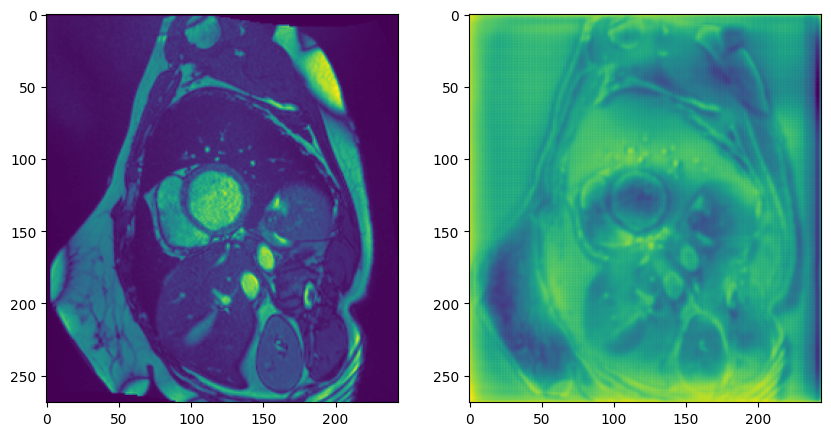

In [ ]:
# plot imshow data, and result, subplot
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(data[0, 0, 3, :, :].detach().numpy())
ax[1].imshow(result[0, 1, 3, :, :].detach().numpy())
plt.show()

# Compare

[[0.23831041 0.38471624 0.43776006 ... 0.2585828  0.23735929 0.13502896]
 [0.34569833 0.5566042  0.64224225 ... 0.41638154 0.37279385 0.21786807]
 [0.35167488 0.5714148  0.67095643 ... 0.4962843  0.42674497 0.24119596]
 ...
 [0.4201496  0.71259457 0.86594033 ... 0.62259054 0.5520757  0.31608874]
 [0.36403704 0.60698825 0.7364427  ... 0.54536515 0.47835    0.27517906]
 [0.18793459 0.31945756 0.39122337 ... 0.2993197  0.26486152 0.14781569]] 

[[0.23831043 0.38471627 0.43776008 ... 0.2585828  0.23735932 0.13502893]
 [0.34569842 0.5566042  0.6422424  ... 0.41638145 0.37279382 0.21786794]
 [0.35167497 0.57141507 0.67095625 ... 0.496284   0.42674482 0.24119592]
 ...
 [0.4201495  0.7125945  0.8659401  ... 0.6225905  0.5520753  0.31608865]
 [0.36403698 0.6069883  0.7364427  ... 0.545365   0.47834992 0.27517897]
 [0.18793452 0.31945744 0.3912233  ... 0.29931965 0.2648614  0.14781567]]
mse:  1.986102e-13


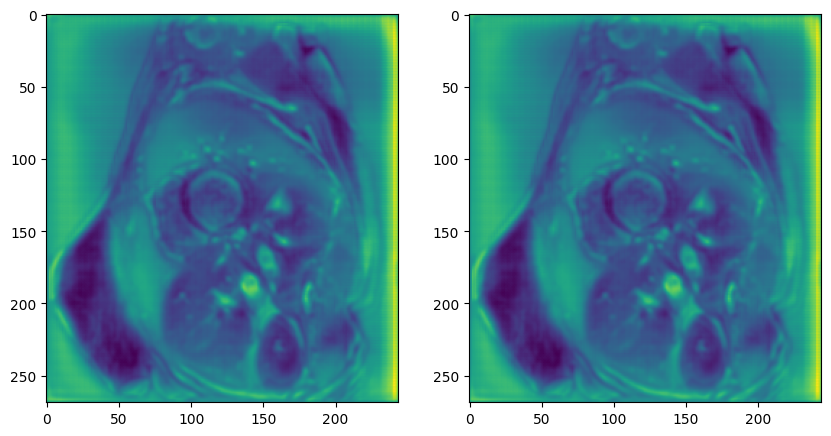

In [ ]:
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
aa = np.load('baseline/conv19.npy') # python
bb = np.load('output/conv3d_21_out.npy') # C
print(aa[0,0,0,:,:], '\n')
print(bb[0,0,0,:,:])
# print mse
print('mse: ', np.mean((aa-bb)**2))

# plot subplots
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(aa[0, 0, 3, :, :])
ax[1].imshow(bb[0, 0, 3, :, :])

In [8]:
# summary model
from torchsummary import summary
model = UNet3D()
summary(model, (1, 32, 32, 32), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 64, 32, 32, 32]           1,792
         LeakyReLU-2       [-1, 64, 32, 32, 32]               0
            Conv3d-3       [-1, 64, 32, 32, 32]         110,656
         LeakyReLU-4       [-1, 64, 32, 32, 32]               0
         MaxPool3d-5       [-1, 64, 32, 16, 16]               0
            Conv3d-6      [-1, 128, 32, 16, 16]         221,312
         LeakyReLU-7      [-1, 128, 32, 16, 16]               0
            Conv3d-8      [-1, 128, 32, 16, 16]         442,496
         LeakyReLU-9      [-1, 128, 32, 16, 16]               0
        MaxPool3d-10        [-1, 128, 16, 8, 8]               0
           Conv3d-11        [-1, 256, 16, 8, 8]         884,992
        LeakyReLU-12        [-1, 256, 16, 8, 8]               0
           Conv3d-13        [-1, 256, 16, 8, 8]       1,769,728
        LeakyReLU-14        [-1, 256, 1

# torchviz

In [ ]:
from torchviz import make_dot
# net
net = UNet3D()
# using torchviz to visualize the network
x = torch.randn(1, 1, 64, 64, 64)
y = net(x)
g = make_dot(y, params=dict(net.named_parameters()))
g.view()

'Digraph.gv.pdf'

# Util

torch.Size([1, 1, 256, 20, 135, 122])
torch.Size([1, 1, 128, 20, 135, 122])
torch.Size([1, 1, 128, 20, 135, 122])


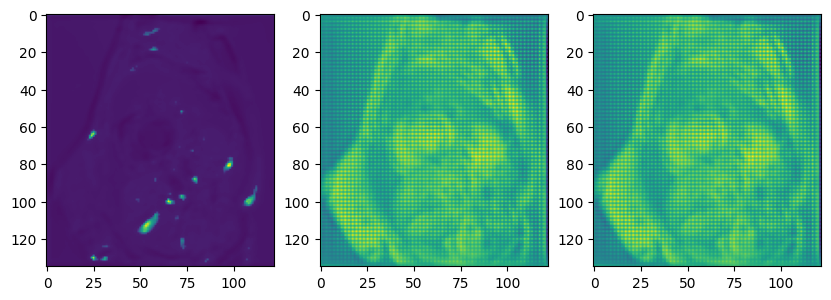

In [34]:
datapath1 = 'conv3d_1-35.npy'
data1 = torch.from_numpy(np.load(datapath1)).float().unsqueeze(0)
print(data1.shape)

datapath2 = 'conv3d_1-36.npy'
data2 = torch.from_numpy(np.load(datapath2)).float().unsqueeze(0)
print(data2.shape)

datapath3 = 'conv3d_17_out.npy'
data3 = torch.from_numpy(np.load(datapath3)).float().unsqueeze(0)
print(data3.shape)

# plot imshow data
fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(data1[0, 0, 0, 3, :, :].detach().numpy())
ax[1].imshow(data2[0, 0, 0, 3, :, :].detach().numpy())
ax[2].imshow(data3[0, 0, 0, 3, :, :].detach().numpy())
plt.show()

# fig, ax = plt.subplots(1, 2, figsize=(10, 10))
# ax[0].imshow(data1[0, 0, :, 3, 1, :].detach().numpy())
# ax[1].imshow(data2[0, 0, :, 3, 1, :].detach().numpy())
# plt.show()

In [26]:
# save data as 'data.txt', split by \n
np.savetxt('conv3d_1-35.txt', data1.detach().numpy().reshape(-1), delimiter='\n')
np.savetxt('conv3d_1-36.txt', data2.detach().numpy().reshape(-1), delimiter='\n')

In [29]:
print(type(np.load(datapath1)), type(data1))

<class 'numpy.ndarray'> <class 'torch.Tensor'>


In [32]:
arr1 = np.load(datapath1)
binary_string1 = arr1.tobytes()
with open('conv3d_1-35.bin', 'wb') as f:
    f.write(binary_string1)

arr2 = np.load(datapath2)
binary_string2 = arr2.tobytes()
with open('conv3d_1-36.bin', 'wb') as f:
    f.write(binary_string2)

In [1]:
#load conv3d_1-36.txt and print 1st 10 lines
with open('conv3d_1-36.txt', 'r') as f:
    for i in range(10):
        print(f.readline())

-1.950399428606033325e-01

-2.887833118438720703e-01

-2.861280739307403564e-01

-3.202245235443115234e-01

-3.166953921318054199e-01

-3.445046544075012207e-01

-3.338376581668853760e-01

-3.570598363876342773e-01

-3.472132384777069092e-01

-3.696740865707397461e-01

